## MA Process

In [4]:
import sys
import pandas as pd
import numpy as np
from numpy import log
from pandas import Series

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

import seaborn as sns

from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [5]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        
        layout  = (3, 2)
        ts_ax   = plt.subplot2grid(layout,(0,0), colspan=2)
        acf_ax  = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax   = plt.subplot2grid(layout,(2,0))
        pp_ax   = plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series analysis plot')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s',ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()),plot=pp_ax)
        
        plt.tight_layout()
    return

In [6]:
# Simulate an MA(1) process

n = int(1000)

#set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas  = np.array([0.6])

#add zero_lag nad negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

In [7]:
ar, ma

(array([ 1., -0.]), array([1. , 0.6]))

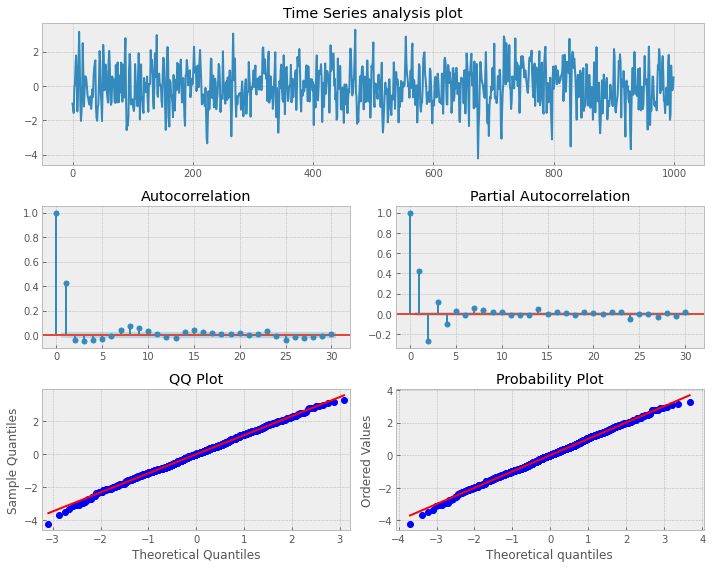

In [8]:
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

_= tsplot(ma1, lags=30)

In [10]:
max_lag = 30
mdl = smt.ARMA(ma1, order=(1,0)).fit(maxlag=max_lag, method='mle', trend='nc')

print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1460.399
Method:                           mle   S.D. of innovations              1.042
Date:                Fri, 09 Apr 2021   AIC                           2924.798
Time:                        16:39:20   BIC                           2934.613
Sample:                             0   HQIC                          2928.528
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4247      0.029     14.840      0.000       0.369       0.481
                                    Roots                                    
                  Real          Imaginary           M

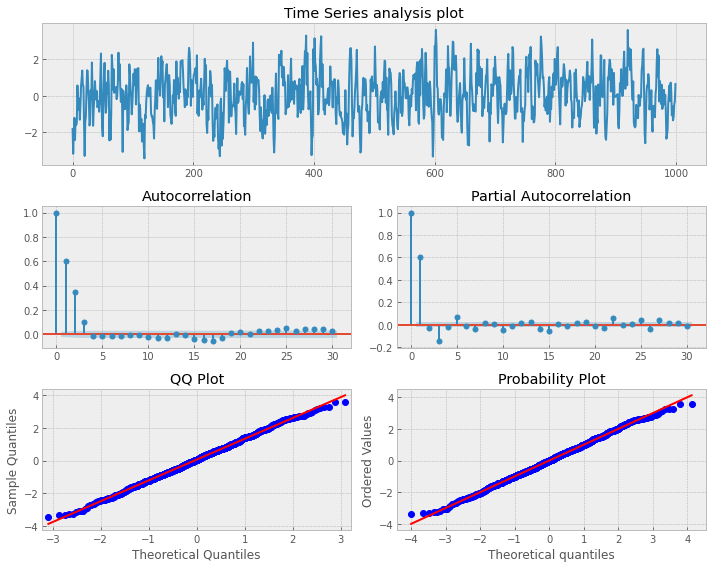

In [11]:
# simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas  = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [12]:
max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1417.011
Method:                           mle   S.D. of innovations              0.998
Date:                Fri, 09 Apr 2021   AIC                           2842.023
Time:                        16:50:04   BIC                           2861.654
Sample:                             0   HQIC                          2849.484
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6182      0.031     19.850      0.000       0.557       0.679
ma.L2.y        0.4656      0.035     13.396      0.000       0.397       0.534
ma.L3.y        0.1930      0.031      6.294      0.0

In [13]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [14]:
data = sm.datasets.sunspots.load_pandas().data

In [16]:
data.index = pd.Index(sm.tsa.datetools.dates_from_range('1700','2008'))
del data['YEAR']

In [17]:
data.head()

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0


<AxesSubplot:>

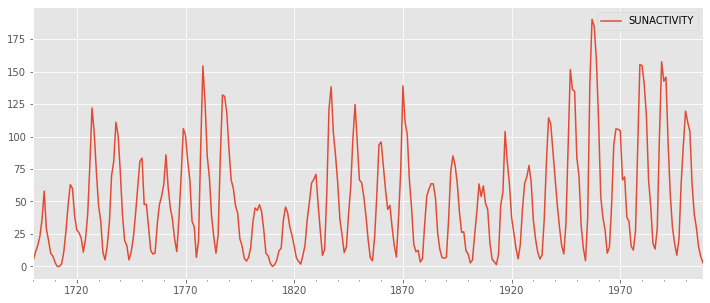

In [18]:
data.plot(figsize=(12, 5))

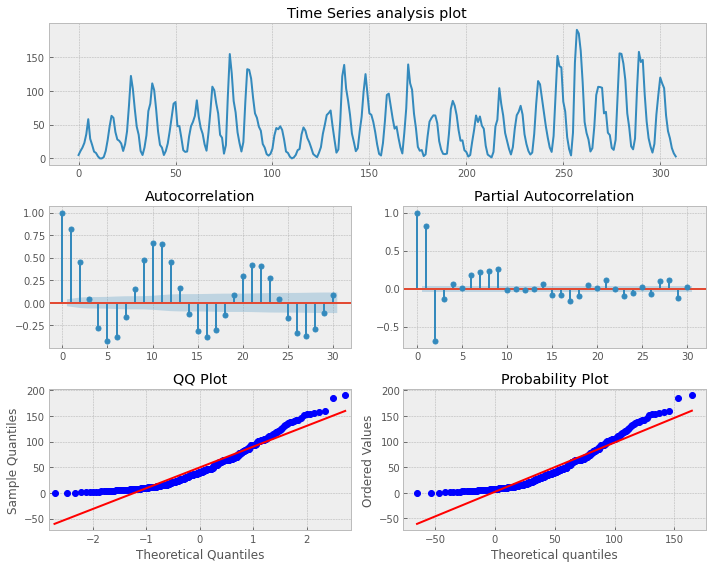

In [19]:
_ = tsplot(data.SUNACTIVITY.values, lags=30)

In [20]:
arma_mod20 = sm.tsa.ARMA(data, (2,0)).fit(disp=False)
print(arma_mod20.params)

const                49.659389
ar.L1.SUNACTIVITY     1.390656
ar.L2.SUNACTIVITY    -0.688571
dtype: float64


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


In [21]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2622.636338063704 2637.569703171295 2628.60672590895


In [22]:
sm.stats.durbin_watson(arma_mod20.resid.values)

2.145826904831452

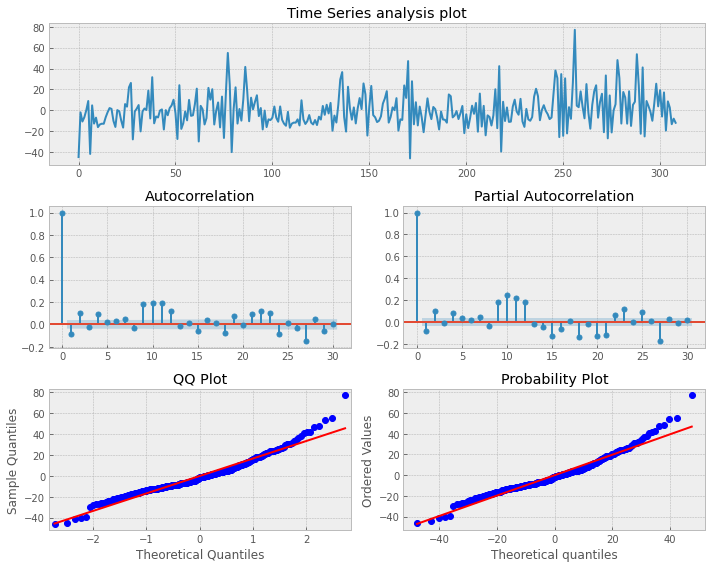

In [23]:
_ = tsplot(arma_mod20.resid.values,lags=30)

In [24]:
stats.normaltest(arma_mod20.resid.values)

NormaltestResult(statistic=41.73601278090119, pvalue=8.652467492294078e-10)

In [25]:
arma_mod22 = sm.tsa.ARMA(data, (2,2)).fit(disp=False)
print(arma_mod22.params)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


const                49.718289
ar.L1.SUNACTIVITY     1.445734
ar.L2.SUNACTIVITY    -0.745660
ma.L1.SUNACTIVITY    -0.140401
ma.L2.SUNACTIVITY     0.069233
dtype: float64


In [26]:
sm.stats.durbin_watson(arma_mod22.resid.values)

1.9694887775842265

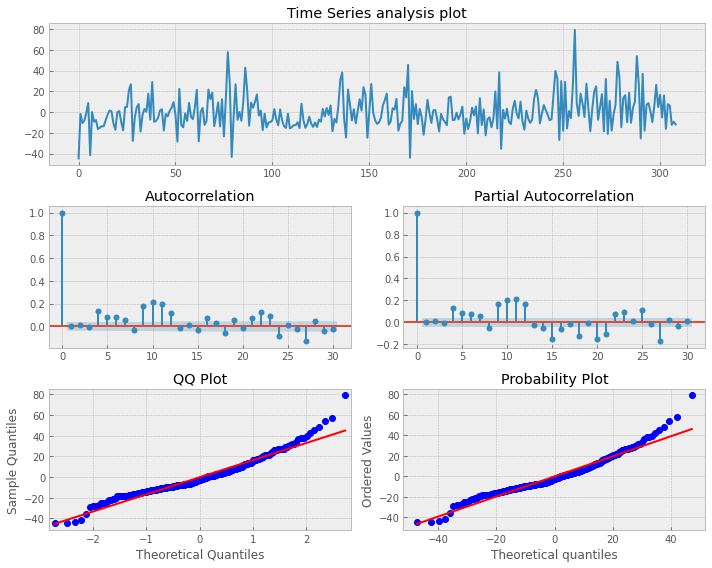

In [27]:
_ = tsplot(arma_mod22.resid.values, lags=30)

In [28]:
stats.normaltest(arma_mod22.resid.values)

NormaltestResult(statistic=48.67031112200971, pvalue=2.7000774611934166e-11)

In [29]:
data = pd.read_csv('datasets/FBExample.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

data.head()

,Close
Date,
2016-11-21,121.769997
2016-11-22,121.470001
2016-11-23,120.839996
2016-11-25,120.379997
2016-11-28,120.410004


In [30]:
data.shape

(251, 1)

In [31]:
data.columns

Index(['Close'], dtype='object')

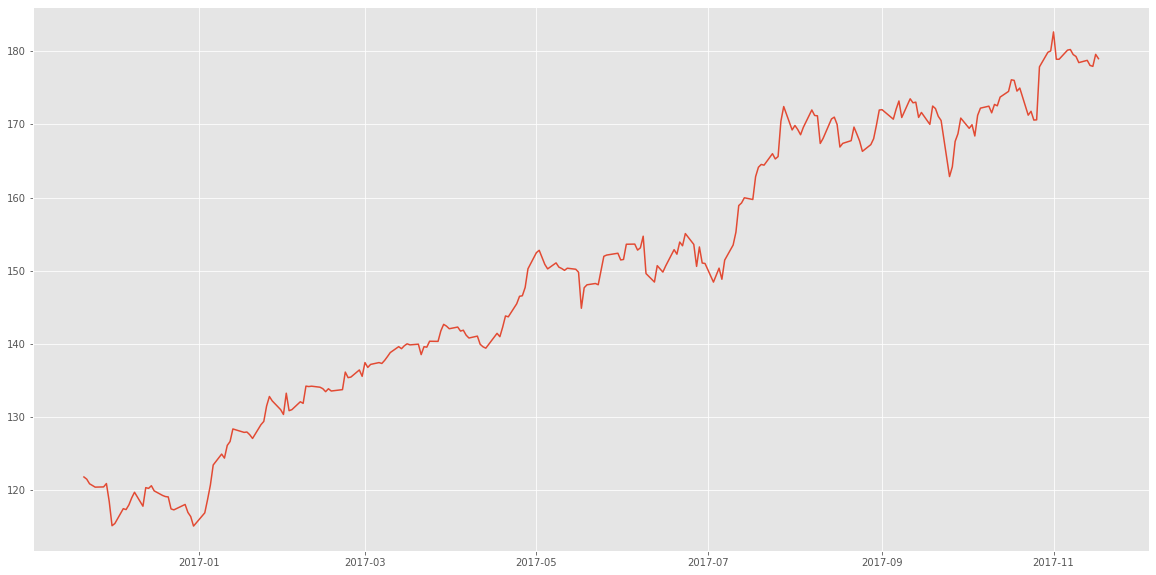

In [33]:
plt.plot(data)

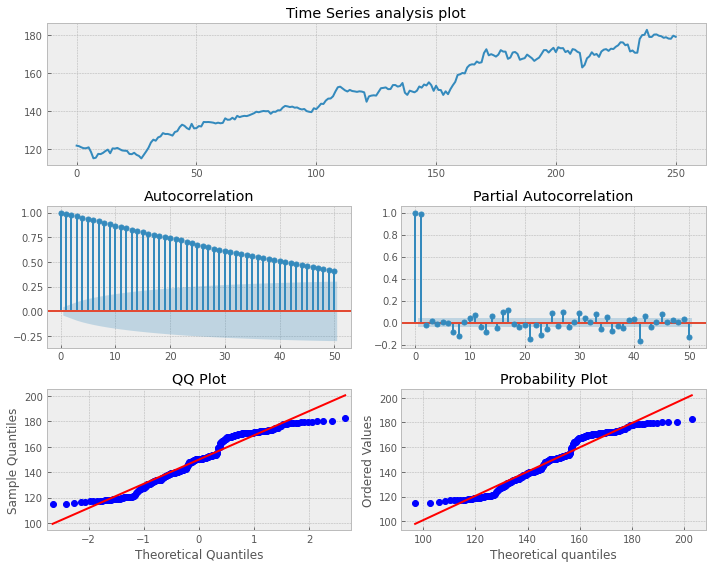

In [35]:
_ = tsplot(data.Close.values, lags=50)

In [36]:
arma_fb = sm.tsa.ARMA(data, (1, 0)).fit(disp = False)
print(arma_fb.params)

const          150.296346
ar.L1.Close      0.998041
dtype: float64


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [37]:
sm.stats.durbin_watson(arma_fb.resid.values)

1.4448299438169574

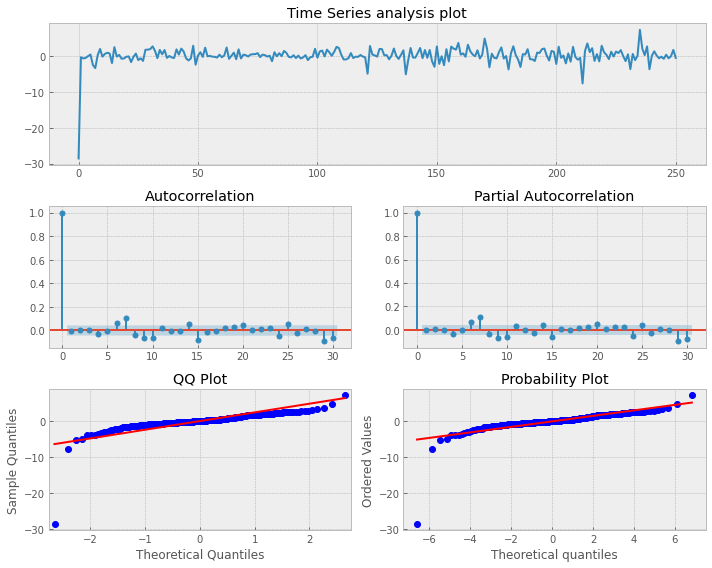

In [38]:
_ = tsplot(arma_fb.resid.values, lags=30)

In [ ]:
stats.normaltest